Authors: Bex Dunn, Vanessa Newey, Neil Symington, Claire Krause, Leo Lymburner

### get some modules

In [19]:
%load_ext autoreload
%autoreload 2

#get modules from standard libraries

import os.path
import numpy as np
import sys
import xarray as xr

from datetime import datetime
import matplotlib.pyplot as plt

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
from RainfallTools import load_rainfall, calculate_residual_mass_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Choose a time period and location to calculate residual mass curve.
 - Note: please select whole months here, not days, as a month with only two days may negatively affect your mass residual curve

In [20]:
## Choose a query area and time
##note: datacube is inclusive of both ends of the interval.

query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2010-01-01', '2013-03-31')
        }

### load rainfall data

In [21]:
#using the BoM grids to 2013. These are out by 2.5km, be aware.

In [22]:
#rainfall = load_rainfall(query)
dc = datacube.Datacube(app='dc-BOMrainfall')
rainfall = dc.load(product = 'bom_rainfall_grids', **query)

## calculate rainfall mass residual

## resample rainfall data to month start ##FIXME, daily option

In [7]:
#we have daily rainfall here.

In [8]:
rainfall

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 3, time: 1186)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 2010-01-03 ...
  * latitude   (latitude) float64 -35.27 -35.32
  * longitude  (longitude) float64 149.1 149.1 149.2
Data variables:
    rainfall   (time, latitude, longitude) float32 1.0589818 1.0485023 ...
Attributes:
    crs:      EPSG:4326

In [9]:
cumulative_rainfall = rainfall.cumsum(dim='time',keep_attrs=True)
cumulative_rainfall=cumulative_rainfall.assign_coords(time=rainfall.coords['time'])
#cumulative_rainfall.groupby('time.dayofyear')

In [ ]:
## Bex version

In [11]:
#resample rainfall data to month start
rainfall_bydayofyear = rainfall.groupby('time.dayofyear')
#dayofyear_rainfall.groups #print groups

In [14]:
rainfall_dayofyear_mean = rainfall.groupby('time.dayofyear').mean(dim='time')

In [ ]:
#rainfall_dayofyear_mean.ra

In [15]:
cumulative_mean_rainfall = rainfall_dayofyear_mean.rainfall[cumulative_rainfall.time.dt.dayofyear-1].cumsum(dim='time',keep_attrs=True)
#rainfall_dayofyear_mean.isel(dayofyear=0).rainfall.plot()

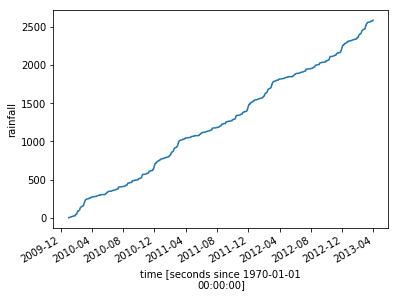

In [16]:
cumulative_mean_rainfall.mean(dim=('latitude','longitude')).plot()

In [17]:
mass_residual= cumulative_rainfall.rainfall-cumulative_mean_rainfall

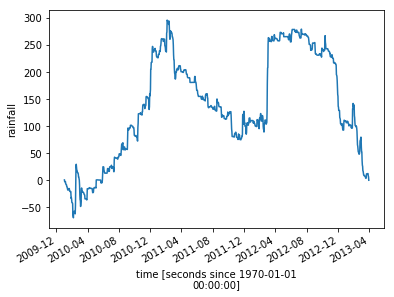

In [18]:
mass_residual.mean(dim=('latitude','longitude')).plot()


In [ ]:
# find the number of years in the data
#years_in_data = len(rainfall.time.dt.month)/12

In [ ]:
years_in_data

In [ ]:
monthly_rainfall

In [ ]:
cumulative_rainfall = monthly_rainfall.cumsum(dim='time')

In [ ]:
monthly_rainfall

In [ ]:
cumulative_rainfall

In [ ]:
monthly_rainfall

In [ ]:
monthly_rainfall.resample

In [ ]:
#cumulative rainfall has lost its time coordinates. can we reattach?

In [ ]:
cumulative_rainfall=cumulative_rainfall.assign_coords(time=monthly_rainfall.coords['time'])

In [ ]:
cumulative_rainfall

In [ ]:

#arr = monthly_rainfall.rainfall.values

#cum_rf = np.cumsum(arr, axis = 0)

In [ ]:
##cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
      #                  coords = [monthly_rainfall.time, monthly_rainfall.latitude, monthly_rainfall.longitude])

In [ ]:
#cum_rf_xr

In [ ]:
# NOw we will calculate a cumulative rainfall assuming average rainfall on a month by month basis
# Find the average of all months
ave_months = rainfall.rainfall.groupby('time.month').mean('time').values

In [ ]:
ave_months.shape

In [ ]:
#d#aily_mean_rainfall.plot(rainfall, time.dayofyear)

In [ ]:
# In the case that we are not starting from January we will need to reorder the array

start_month = rainfall.time[0].dt.month.values - 1

ave_month = np.concatenate((ave_months[start_month:,:,:], ave_months[0:start_month,:,:]), axis = 0)

In [ ]:
ave_month.shape

In [ ]:
# Tile an array so that we can run a cumulative sum on it
tiled_ave = np.tile(ave_months, (round(years_in_data), 1, 1))

In [ ]:
tiled_ave

In [ ]:
# In the case that we have residual months remove them from the tiled array
if (years_in_data).is_integer() == False:
    month_remainder = int(round((n%1) * 12))

    tiled_ave = tiled_ave[:int(-month_remainder),:,:]
    

In [ ]:
# Generate the cumulative sum of rainfall one would get assuming average rainfall every month
cum_ave = np.cumsum(tiled_ave, axis = 0)

In [ ]:
cum_ave.shape

In [ ]:
monthly_rainfall

In [ ]:
cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
                          coords = [monthly_rainfall.time, monthly_rainfall.latitude, monthly_rainfall.longitude])

In [ ]:
# The mass residual curve is the difference between the cumulative rainfall data and the cumulative
# rainfall one would get iff the average always occured
mass_res_curve = cum_rf_xr - cum_ave_xr

mass_res_curve

In [ ]:
#mass_res_curve.plot(col='time', col_wrap=6)
mass_res_curve.mean.plot()

In [ ]:
xr.broadcast()

In [25]:
# def calculate_residual_mass_curve(a):
#     '''This function calculates the residual mass rainfall curve
#     :param a: '''
    
#     #resample rainfall data to month start
#     a = a.resample('MS', dim='time', how='sum', keep_attrs=True) 
#     # find the number of time steps (ie. years)
#     n = len(a.rainfall.time)/12
    
#     # First calculate a cumulative rainfall xarray from the rainfall data
    
#     arr = a.rainfall.values
    
#     cum_rf = np.cumsum(arr, axis = 0)
    
#     cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
#                             coords = [a.time, a.latitude, a.longitude])
    
#     # NOw we will calculate a cumulative rainfall assuming average rainfall on a month by month basis
#     # Find the average of all months
#     ave_months = a.rainfall.groupby('time.month').mean('time').values
   
#     # In the case that we are not starting from January we will need to reorder the array
    
#     start_month = a.time[0].dt.month.values - 1
    
#     ave_month = np.concatenate((ave_months[start_month:,:,:], ave_months[0:start_month,:,:]), axis = 0)

    
#     # Tile an array so that we can run a cumulative sum on it
#     tiled_ave = np.tile(ave_months, (round(n), 1, 1))
    
#     # In the case that we have residual months remove them from the tiled array
#     if (n).is_integer() == False:
#         month_remainder = int(round((n%1) * 12))

#         tiled_ave = tiled_ave[:int(-month_remainder),:,:]
        
#     # Generate the cumulative sum of rainfall one would get assuming average rainfall every month
#     cum_ave = np.cumsum(tiled_ave, axis = 0)
    
#     cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
#                               coords = [a.time, a.latitude, a.longitude])
    
#     # The mass residual curve is the difference between the cumulative rainfall data and the cumulative
#     # rainfall one would get iff the average always occured
#     mass_res_curve = cum_rf_xr - cum_ave_xr
    
#     return mass_res_curve


## calculate metrics based on rainfall
- increasing and decreasing periods
- wet year after dry years
- dry year after wet years
-

## calculate metrics based on residual rainfall
- increasing and decreasing periods
- wet year after dry years
- dry year after wet years


## calculate seasonality
- Koppen climate region (use notebook to follow decision tree - requires climate data)
- Summer dominant, Summer, Uniform, Winter, Winter dominant #
- TROP SOI value
- IOD /SAM indices
"During El Niño, rainfall in eastern Australian is typically below average during winter and spring. A neutral ENSO phase has little effect on Australian climate."Bureau of meteorology http://www.bom.gov.au/climate/enso/  

In [39]:
# Calculate failed wet seasons - calculate total wet season + dry season rainfalls
# (end of wet season rainfalls?)